In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
pd.options.display.max_colwidth = 400
import warnings
import csv
warnings.filterwarnings('ignore')

### Data cleaning and Data Pre-Processing

In [2]:
selected_columns = ['subreddit','selftext', 'author', 'title', 'score','num_comments','utc_datetime_str']

In [3]:
df_aws = pd.read_csv('../data/aws_subreddit.csv')[selected_columns]
df_az = pd.read_csv('../data/az_subreddit.csv')[selected_columns]

In [4]:
##Cleaning
def check_dataframe(df):
    print(f"Data frame shape: {df.shape}")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")


In [5]:
check_dataframe(df_aws)

Data frame shape: (4998, 7)
Empty rows in column [selftext]: 879
Rows with zeroes in column [score]: 27
Rows with zeroes in column [num_comments]: 4400
Columns with data type [int64]:['score', 'num_comments']
Columns with data type [object]:['subreddit', 'selftext', 'author', 'title', 'utc_datetime_str']


In [6]:
check_dataframe(df_az)

Data frame shape: (4996, 7)
Empty rows in column [selftext]: 972
Rows with zeroes in column [score]: 44
Rows with zeroes in column [num_comments]: 4099
Columns with data type [int64]:['score', 'num_comments']
Columns with data type [object]:['subreddit', 'selftext', 'author', 'title', 'utc_datetime_str']


In [7]:

# Drop num_comments column
# Remove [removed], \n, links, [deleted] placeholders
# Remove less than 10char
# Combine title and self text into message

df_aws[~df_aws['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str
0,aws,[removed],BrianPRegan,AWS Pricing Add-on for Google Sheets,1,0,2023-03-10 16:28:11
1,aws,[removed],Winter_Sucks_7868,Kansas AWS,1,0,2023-03-10 15:52:40
2,aws,"We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth.\n\nWell there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass.\n\nIf a aws VPN is set the ""dynamic"" will it only pass routes it learns via BGP? You can't add a static also?",silicondt,VPN - dynamic - can we put one static also?,1,0,2023-03-10 15:20:34
3,aws,"Hi,\n\nWhat would be the best instance for a ""Whisper"" machine ? (OpenAI's transcription program). I would need to use this machine for a few hours a month only and I need 10GB of VRAM (at least the ""large"" model).\n\nThanks",Juythar,"Best Instance for a ""Whisper"" Machine?",1,0,2023-03-10 14:30:25
4,aws,Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [https://overmind.tech/blog/cloud-infrastructure-diagrams](https://overmind.tech/blog/cloud-infrastructure-diagrams),jameslaney,"Anyone using Workload Discovery? We’re building an alternative, what features do people actually use?",1,0,2023-03-10 13:50:36
...,...,...,...,...,...,...,...
4988,aws,"We are doing some house cleaning and have some instances that appear to be unused. I'm unsure of how to find out when these instances were stopped. I suppose I could start each one in question and look at its logs, but there must be a better way.",PeterPanLives,How can I see when an instance was stopped?,4,8,2017-01-02 19:26:11
4990,aws,With the recent price drop of S3 Standard Storage to $0.023 it is now cheaper than the Reduced Redundancy Storage option that is still $0.024. Does anyone know what is going on? Are they trying to get rid of the RRS option?,FortLouie,Why is S3 RRS more expensive than standard?,3,4,2017-01-02 19:19:21
4991,aws,"Hi all, I'm working on this cfn template and running into an issue setting up a Conditional for an optional CommaDelimitedList parameter. When I run the following though, the API reports an error: *every Fn::Equals object requires a list of 2 string parameters.* \n\n Parameters:\n SomeParam:\n Description: &gt;-\n (Optional) Comma separated list of things.\n Type...",inhumantsar,CloudFormation Condition on CommaDelimitedList,7,9,2017-01-02 17:38:02
4996,aws,"**Happy New Year!** \n\nI've been working on collecting data for a while that is basically latency between all of the different AWS regions. There have been several times over the course of last year where I had been working with a client on trying to quantify latency between different AWS regions - I found lots of static, or old data, but nothing that was really up to date. \n\nSo I made this...",mda90,Latency Between AWS Regions monitoring tool,2,1,2017-01-02 01:04:13


In [8]:
df_az[~df_az['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str
0,AZURE,This week's Azure Infrastructure Update is up.\n\nhttps://youtu.be/f\_e8E4HIQVA,JohnSavill,Azure Infrastructure Weekly Update - 10th March 2023,1,0,2023-03-10 14:17:31
1,AZURE,"Reposting for more favorable hours of the day...\n\nQuick and potentially dumb question...\n\nSetting up a GCC tenant + Azure Commercial for an AVD deployment. However, none of the government equivalent licenses include the Windows desktop entitlement for AVD.\n\nThere some secret sauce for getting that or is GCC a bust?",wheres_my_toast,AVD licensing in GCC?,1,0,2023-03-10 14:13:42
2,AZURE,Where is the best place to go for an issue with a GraphAPI. I am having issues with this one here: \n\n[https://graph.microsoft.com/{version}/sites/{id}/onenote/](https://graph.microsoft.com/{version}/sites/{id}/onenote/){notebooks | sections | sectionGroups | pages}\n\nWhen sending a GET request to [https://graph.microsoft.com/v1.0/sites/{id}/onenote/](https://graph.microsoft.com/{version}/s...,gschellhas,Issue with Graph API Endpoint: OneNote Sites,1,0,2023-03-10 14:10:53
3,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error:\n\n*The client 'xxxxxxxxxxxxxxxx' with object id 'xxxxxxxxxxxxxxx' does not have authorization to perform action 'Microsoft.Logic/register/action' ove...",ivansk81,Azure Sentinel - Playbook Permission,1,0,2023-03-10 13:37:48
4,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n \n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error. What im missing?",ivansk81,Microsoft Sentinel - Playbook Permissions,1,0,2023-03-10 13:34:17
...,...,...,...,...,...,...,...
4989,AZURE,I am setting up some azure accounts for the first time. I will have one server running .Net open to the internet. I will other servers for our SAP ERP system. I want to avoid the scenario where if our web facing server is hacked they can get access to our ERP server. Would I be safer to setup the Web and ERP servers under different Azure accounts?,chinguetti,"New to Azure. Safe to put webservers, ERP servers on same Azure account?",5,3,2016-04-17 09:25:47
4990,AZURE,[deleted],[deleted],"Database is in SSMS but ""not found"" error in the portal?",6,3,2016-04-16 19:34:54
4991,AZURE,"# Background\nWe are using azure for a SaaS I am building. Still in the early days with only a handful of users. The product is a .Net + SQL server + blob storage back end, and lots of typescript and less on the front end). We use code first migrations. Using Git-Flow workflow.\n\nWe want a 3 tier approach with dev/test/prod. Originally I had just set up a 3 DB’s on the same server, and use ...",snowsquirrel,"Could I get some feedback on my Azure usage, please.",4,3,2016-04-16 19:20:28
4992,AZURE,"Let's say I have a program on my PC/Server (veeam / shadowprotect) that is doing daily snapshots of my computer/server. I want to test this in conjunction with Windows Azure file / folder backup.\n\n*Retention policy - Assuming veeam / shadowprotect manage the backup jobs, retention policy should be set at 1 day on the azure backup jobs because my local backup software is handling the retentio...",yutz23,Windows Azure Backup Question(s),2,1,2016-04-15 23:37:01


In [9]:

def combine_title_message(df):
    df['fullmessage'] = df['title'] + (' ' + df['selftext']).fillna('')
    return df

df_aws = combine_title_message(df_aws)
df_aws[df_aws['selftext'].isna()].head(3)

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
5,aws,NaN,MaxGanzII,Redshift Research Project : varbyte sorting (blog post),1,0,2023-03-10 13:06:15,Redshift Research Project : varbyte sorting (blog post)
7,aws,NaN,DodeYoke,Using AWS CLI to create and manage functions in Lambda,1,0,2023-03-10 11:58:20,Using AWS CLI to create and manage functions in Lambda
13,aws,NaN,Gleb--K,Amazon DynamoDB now supports table deletion protection,1,0,2023-03-10 07:49:00,Amazon DynamoDB now supports table deletion protection


In [10]:
df_az = combine_title_message(df_az)
df_az[df_az['selftext'].isna()].head(3)

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
20,AZURE,NaN,IAmTwoSixNine,Azure Front Door path mapping 404 aborted,1,0,2023-03-10 04:42:21,Azure Front Door path mapping 404 aborted
34,AZURE,NaN,NaViFanYearDntMatter,"Looking at the cost breakdown of a VM, what is the last row and what could be the reasons for it to be $0?",1,0,2023-03-09 15:52:39,"Looking at the cost breakdown of a VM, what is the last row and what could be the reasons for it to be $0?"
47,AZURE,NaN,Emma__24,Enable report suspicious activity in Azure AD to stay alerted on suspicious MFA requests!,1,0,2023-03-09 10:40:45,Enable report suspicious activity in Azure AD to stay alerted on suspicious MFA requests!


In [11]:
import re

pattern = re.compile('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+')
comment = str(df_aws.iloc[[4]]['fullmessage'])

print(f"Before: {comment}")
print(f"After: {pattern.sub('', comment)}")

Before: 4    Anyone using Workload Discovery? We’re building an alternative, what features do people actually use? Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [https://overmind.tech/blog/cloud-infrastructure-diagrams](https://overmind.tech/blog...
Name: fullmessage, dtype: object
After: 4    Anyone using Workload Discovery? We’re building an alternative, what features do people actually use? Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [](
Name: fullmessage, dtype: object


In [12]:
import re

def clean(text, newline=True, quote=True, bullet_point=True, 
          link=True, strikethrough=True, spoiler=True,
          code=True, superscript=True, table=True, heading=True):
    """
    Cleans text (string).
    Removes common Reddit special characters/symbols:
      * \n (newlines)
      * &gt; (> quotes)
      * * or &amp;#x200B; (bullet points)
      * []() (links)
      * etc (see below)
    Specific removals can be turned off, but everything is on by default.
    Standard punctuation etc is deliberately not removed, can be done in a
    second round manually, or may be preserved in any case.
    """
    # Newlines (replaced with space to preserve cases like word1\nword2)
    if newline:
        text = re.sub(r'\n+', ' ', text)

        # Remove resulting ' '
        text = text.strip()
        text = re.sub(r'\s\s+', ' ', text)

    # > Quotes
    if quote:
        text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Bullet points/asterisk (bold/italic)
    if bullet_point:
        text = re.sub(r'\*', '', text)
        text = re.sub('&amp;#x200B;', '', text)

    # []() Link (Also removes the hyperlink)
    if link:
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Strikethrough
    if strikethrough:
        text = re.sub('~', '', text)

    # Spoiler, which is used with < less-than (Preserves the text)
    if spoiler:
        text = re.sub('&lt;', '', text)
        text = re.sub(r'!(.*?)!', r'\1', text)

    # Code, inline and block
    if code:
        text = re.sub('`', '', text)

    # Superscript (Preserves the text)
    if superscript:
        text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Table
    if table:
        text = re.sub(r'\|', ' ', text)
        text = re.sub(':-', '', text)

    # Heading
    if heading:
        text = re.sub('#', '', text)

    return text

In [13]:
import numpy as np

def replace_text(df,col):
    df[col]=df[col].astype(str)
    pattern = re.compile('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+')
    df[col]=df[col].apply(lambda x: pattern.sub('', str(x)))
    df[col]=df[col].str.replace('\n', ' ')
    df[col]=df[col].str.replace('\[removed\]', '')
    df[col]=df[col].str.replace('\[deleted\]', '')
    df[col]=df[col].str.replace('\[\]\(\)', '') 
    df[col]=df[col].apply(lambda x: clean(str(x)))
    return df
    
df_aws = replace_text(df_aws,'fullmessage')
df_az = replace_text(df_az,'fullmessage')

In [14]:
df_aws[~df_aws['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
0,aws,[removed],BrianPRegan,AWS Pricing Add-on for Google Sheets,1,0,2023-03-10 16:28:11,AWS Pricing Add-on for Google Sheets
1,aws,[removed],Winter_Sucks_7868,Kansas AWS,1,0,2023-03-10 15:52:40,Kansas AWS
2,aws,"We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth.\n\nWell there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass.\n\nIf a aws VPN is set the ""dynamic"" will it only pass routes it learns via BGP? You can't add a static also?",silicondt,VPN - dynamic - can we put one static also?,1,0,2023-03-10 15:20:34,"VPN - dynamic - can we put one static also? We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth. Well there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass. If a aws VPN is set the ""dynamic"" will it only pass routes it learns ..."
3,aws,"Hi,\n\nWhat would be the best instance for a ""Whisper"" machine ? (OpenAI's transcription program). I would need to use this machine for a few hours a month only and I need 10GB of VRAM (at least the ""large"" model).\n\nThanks",Juythar,"Best Instance for a ""Whisper"" Machine?",1,0,2023-03-10 14:30:25,"Best Instance for a ""Whisper"" Machine? Hi, What would be the best instance for a ""Whisper"" machine ? (OpenAI's transcription program). I would need to use this machine for a few hours a month only and I need 10GB of VRAM (at least the ""large"" model). Thanks"
4,aws,Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [https://overmind.tech/blog/cloud-infrastructure-diagrams](https://overmind.tech/blog/cloud-infrastructure-diagrams),jameslaney,"Anyone using Workload Discovery? We’re building an alternative, what features do people actually use?",1,0,2023-03-10 13:50:36,"Anyone using Workload Discovery? We’re building an alternative, what features do people actually use? Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for. What we're doing:"
...,...,...,...,...,...,...,...,...
4988,aws,"We are doing some house cleaning and have some instances that appear to be unused. I'm unsure of how to find out when these instances were stopped. I suppose I could start each one in question and look at its logs, but there must be a better way.",PeterPanLives,How can I see when an instance was stopped?,4,8,2017-01-02 19:26:11,"How can I see when an instance was stopped? We are doing some house cleaning and have some instances that appear to be unused. I'm unsure of how to find out when these instances were stopped. I suppose I could start each one in question and look at its logs, but there must be a better way."
4990,aws,With the recent price drop of S3 Standard Storage to $0.023 it is now cheaper than the Reduced Redundancy Storage option that is still $0.024. Does anyone know what is going on? Are they trying to get rid of the RRS option?,FortLouie,Why is S3 RRS more expensive than standard?,3,4,2017-01-02 19:19:21,Why is S3 RRS more expensive than standard? With the recent price drop of S3 Standard Storage to $ it is now cheaper than the Reduced Redundancy Storage option that is still $ Does anyone know what is going on? Are they trying to get rid of the RRS option?
4991,aws,"Hi all, I'm working on this cfn template and running into an issue setting up a Conditional for an optional CommaDelimitedList parameter. When I run the following though, the API reports an error: *every Fn::Equals obje

In [15]:
df_az[~df_az['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
0,AZURE,This week's Azure Infrastructure Update is up.\n\nhttps://youtu.be/f\_e8E4HIQVA,JohnSavill,Azure Infrastructure Weekly Update - 10th March 2023,1,0,2023-03-10 14:17:31,Azure Infrastructure Weekly Update - 10th March 2023 This week's Azure Infrastructure Update is up. \_e8E4HIQVA
1,AZURE,"Reposting for more favorable hours of the day...\n\nQuick and potentially dumb question...\n\nSetting up a GCC tenant + Azure Commercial for an AVD deployment. However, none of the government equivalent licenses include the Windows desktop entitlement for AVD.\n\nThere some secret sauce for getting that or is GCC a bust?",wheres_my_toast,AVD licensing in GCC?,1,0,2023-03-10 14:13:42,"AVD licensing in GCC? Reposting for more favorable hours of the Quick and potentially dumb Setting up a GCC tenant + Azure Commercial for an AVD deployment. However, none of the government equivalent licenses include the Windows desktop entitlement for AVD. There some secret sauce for getting that or is GCC a bust?"
2,AZURE,Where is the best place to go for an issue with a GraphAPI. I am having issues with this one here: \n\n[https://graph.microsoft.com/{version}/sites/{id}/onenote/](https://graph.microsoft.com/{version}/sites/{id}/onenote/){notebooks | sections | sectionGroups | pages}\n\nWhen sending a GET request to [https://graph.microsoft.com/v1.0/sites/{id}/onenote/](https://graph.microsoft.com/{version}/s...,gschellhas,Issue with Graph API Endpoint: OneNote Sites,1,0,2023-03-10 14:10:53,"Issue with Graph API Endpoint: OneNote Sites Where is the best place to go for an issue with a GraphAPI. I am having issues with this one here: {notebooks sections sectionGroups pages} When sending a GET request to notebooks it returns a \\\ The OData query is invalid. The URI segment 'notebooks' is invalid after the segment 'notes'. \\\ Where can I report the bug, if it is one. Can anyo..."
3,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error:\n\n*The client 'xxxxxxxxxxxxxxxx' with object id 'xxxxxxxxxxxxxxx' does not have authorization to perform action 'Microsoft.Logic/register/action' ove...",ivansk81,Azure Sentinel - Playbook Permission,1,0,2023-03-10 13:37:48,"Azure Sentinel - Playbook Permission Hi, i have the following permission in Microsoft Sentinel: Microsoft Sentinel Playbook Operator Microsoft Sentinel Automation Contributor Microsoft Sentinel Contributor Anyway i can't create playbooks, i receive following error: The client 'xxxxxxxxxxxxxxxx' with object id 'xxxxxxxxxxxxxxx' does not have authorization to perform action '' over scope '/su..."
4,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n \n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error. What im missing?",ivansk81,Microsoft Sentinel - Playbook Permissions,1,0,2023-03-10 13:34:17,"Microsoft Sentinel - Playbook Permissions Hi, i have the following permission in Microsoft Sentinel: Microsoft Sentinel Playbook Operator Microsoft Sentinel Automation Contributor Microsoft Sentinel Contributor Anyway i can't create playbooks, i receive following error. What im missing?"
...,...,...,...,...,...,...,...,...
4989,AZURE,I am setting up some azure accounts for the first time. I will have one server running .Net open to the internet. I will other servers for our SAP ERP system. I want to avoid the scenario where if our web facing server is hacked they can get access to our ERP server. Would I be safer to setup the Web and ERP servers under different Azure accounts?,chinguetti,"New to Azure. Safe to put webservers, ERP servers on same Azure account?",5,3,2016-04-17 09:25:47,"New 

In [16]:
def add_counts(df):
    df['text_length'] = df['fullmessage'].astype(str).map(len)
    df['text_word_count'] = df['fullmessage'].astype(str).map(lambda x: len(x.split()))
    #print(df.sort_values(by='text_word_count', ascending=False)[['selftext']].head(3))

add_counts(df_aws)
add_counts(df_az)

Text(0.5, 1.0, 'AWS posts')

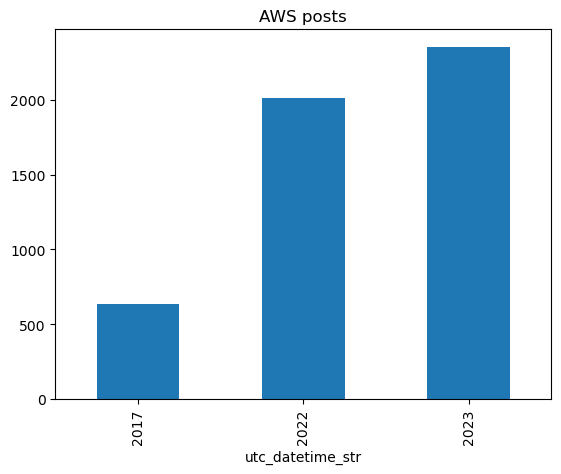

In [17]:
df_aws['fullmessage'].groupby(pd.to_datetime(df_aws['utc_datetime_str']).dt.year).count().plot(kind="bar")
plt.title('AWS posts')

Text(0.5, 1.0, 'Azure posts')

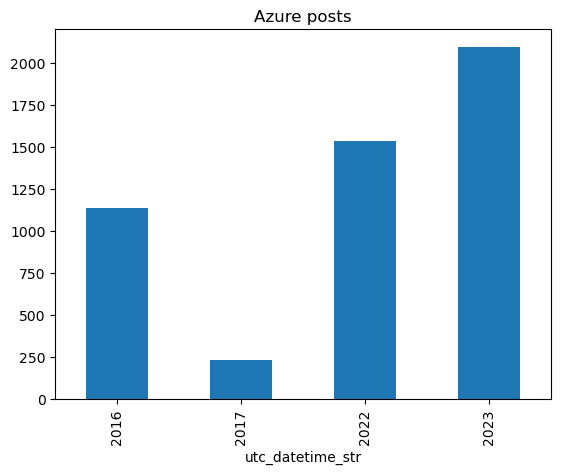

In [18]:
df_az['fullmessage'].groupby(pd.to_datetime(df_az['utc_datetime_str']).dt.year).count().plot(kind="bar")
plt.title('Azure posts')

In [19]:
df_aws[df_aws['text_word_count'] <2]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count
91,aws,[removed],Jade12_CM,Question?,1,0,2023-03-08 11:08:21,Question?,9,1
580,aws,[removed],Acrobatic-Emu8229,Cloud9,1,0,2023-02-22 18:04:14,Cloud9,6,1
685,aws,[removed],New-Comfortable-5912,Help,1,0,2023-02-18 17:38:53,Help,4,1
930,aws,[removed],TechGeekMica,Capacity,1,0,2023-02-12 04:41:49,Capacity,8,1
1073,aws,[removed],maedo,botocore.awsrequest.AWSRequest object,1,0,2023-02-07 18:48:22,object,6,1
1080,aws,NaN,094459,https://dev.to/aws/aws-open-source-newsletter-144-22h,1,0,2023-02-07 13:22:36,,0,0
1187,aws,[removed],Altruistic-Fish-1510,Question,1,0,2023-02-03 20:26:27,Question,8,1
1212,aws,[removed],paololazzari,cloudtrail-event-fuzzy-viewer,1,0,2023-02-03 11:09:38,cloudtrail-event-fuzzy-viewer,29,1
1411,aws,NaN,Express-Cartoonist-6,Hhh,1,0,2023-01-28 17:32:12,Hhh,3,1
1418,aws,NaN,Dingydongu,help,1,0,2023-01-28 10:43:26,help,4,1


In [20]:
df_az[df_az['text_word_count'] <2]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count
89,AZURE,[removed],arslan104,solitaire-mahjong-juicy,1,0,2023-03-08 08:19:17,solitaire-mahjong-juicy,23,1
175,AZURE,NaN,ggddgdseh,Azure,1,0,2023-03-05 18:38:29,Azure,5,1
2156,AZURE,http://f88ff.Wordpress.com,Kitchen_Recipe_2848,404,1,0,2022-12-28 14:17:14,404,3,1
2866,AZURE,NaN,Kanetheamerican,Twitch,1,0,2022-11-29 18:19:09,Twitch,6,1
2946,AZURE,[removed],Erys19_,Powerbi,1,0,2022-11-26 01:04:55,Powerbi,7,1
3577,AZURE,[removed],Beautiful-Relief1004,https://new-google-apps.blogspot.com/2022/11/filmorago-video-editor-maker-mod-apk.html,1,0,2022-11-06 11:16:06,,0,0
3590,AZURE,[removed],Beautiful-Relief1004,https://new-google-apps.blogspot.com/2022/11/download-bowmasters-mod-unlimited-coins.html,1,0,2022-11-05 09:10:08,,0,0
3612,AZURE,[removed],Beautiful-Relief1004,https://new-google-apps.blogspot.com/2022/11/download-kingdom-wars-mod-unlimited.html,1,0,2022-11-04 14:35:16,,0,0
3934,AZURE,NaN,azeddineazeddine,hghkk,0,3,2016-12-15 10:41:09,hghkk,5,1
4087,AZURE,Our SQL Tools teams are going live 9:30am - 2pm PST answering all your questions. Check it out over at [/r/SQLServer](https://www.reddit.com/r/SQLServer/comments/5dijyg/ama_microsoft_sql_server_1118/),AzureSupport,[AMA] Microsoft SQL Server - 11/18 (xpost from /r/SQLServer),2,0,2016-11-18 17:31:16,,0,0


<AxesSubplot:title={'center':'AWS posts'}, xlabel='text_word_count', ylabel='Density'>

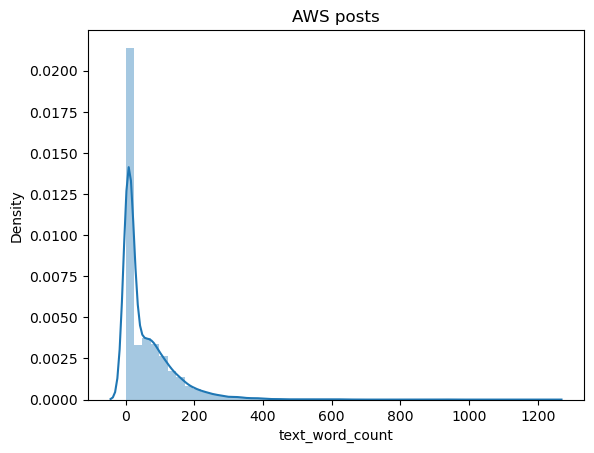

In [21]:
plt.title('AWS posts')
sns.distplot(df_aws['text_word_count'])

<AxesSubplot:title={'center':'Azure posts length'}, xlabel='text_word_count', ylabel='Density'>

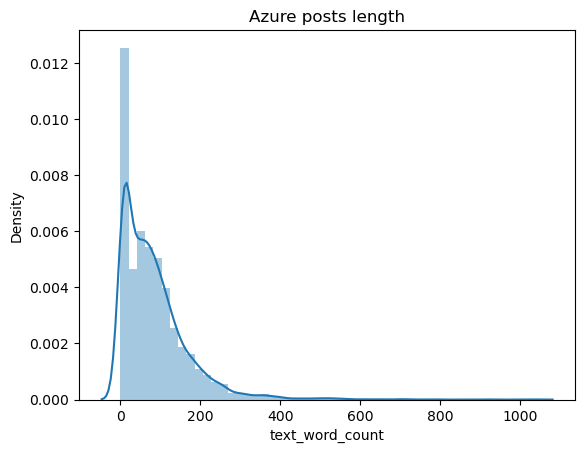

In [22]:
plt.title('Azure posts length')
sns.distplot(df_az['text_word_count'])

In [23]:
## Remove rows where fullmessage <= 2 words

df_aws = df_aws[df_aws['text_word_count'] > 2]
df_az = df_az[df_az['text_word_count'] > 2]

df_aws.shape

(4908, 10)

In [24]:
df_az.shape

(4969, 10)

In [25]:
# Word count

def get_word_vectors(df_col):
    cv = CountVectorizer(stop_words='english', min_df=3)
    cv.fit(df_col)
    df_cv = cv.transform(df_col)
    result = pd.DataFrame(df_cv.todense(), columns=cv.get_feature_names_out())
    return result

<AxesSubplot:>

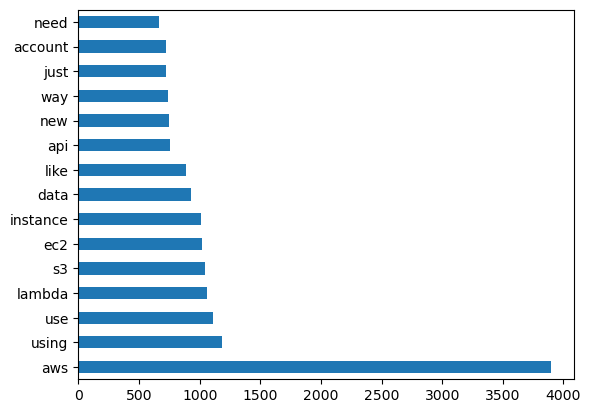

In [26]:
aws = get_word_vectors(df_aws['fullmessage'])
aws.sum().sort_values(ascending=False).head(15).plot(kind='barh')

<AxesSubplot:>

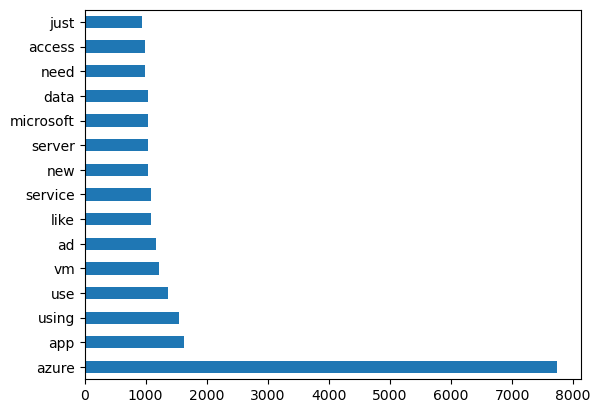

In [27]:
az = get_word_vectors(df_az['fullmessage'])
az.sum().sort_values(ascending=False).head(15).plot(kind='barh')

In [28]:
#Investigate common words

def investigate(df_col,word):
    matched_list = [text for text in df_col if word in text.lower()]
    print(matched_list[:10])

In [29]:
investigate(df_aws['fullmessage'],'x200b')

[]


In [30]:
investigate(df_aws['fullmessage'],'&amp')

["Automate Boring Stuffs with AWS Batch Fargate &amp; AWS EventBridge ;utm_medium=member_android In this medium blog you can learn how to automate the task which is AWS RDS Database Dump to AWS S3 on Regular Time Stamp also using AWS Batch Fargate to reduce the cost as low as possible. I've worked on this task from scratch and it was first time interaction with this technology so i beleive there might be a lot of possibilities to improve the setup which I've shown in the blog. Any kind of Feedback is appreciated Thank you", 'AWS SSO &amp; Inline Policies', 'Regarding Network security On the below use case, where only the ELB has access to the internet and the other two tiers are isolated, how would you go about updating the OS/App in the EC2 appliance?  ;format=png&amp;auto=webp&amp;v=enabled&amp;s=512a84c0822412e62fada007e60914f4d882748b', 'Event Design &amp; Event-first Development', 'CodeDeploy - How to start a project that runs with a command that \'does not finish\' Issue Code Dep

In [31]:
# combine the data

df = pd.concat([df_aws,df_az])
df.shape

(9877, 10)

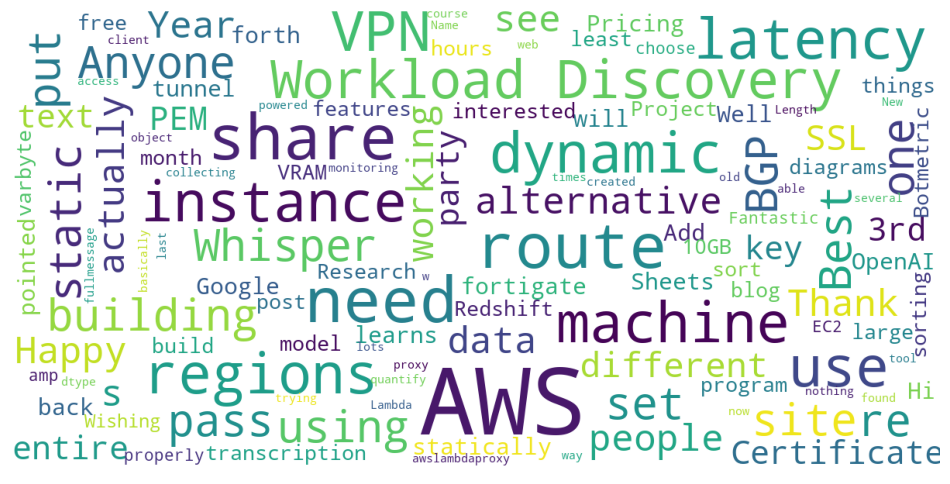

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df[df['subreddit']=='aws']['fullmessage'])

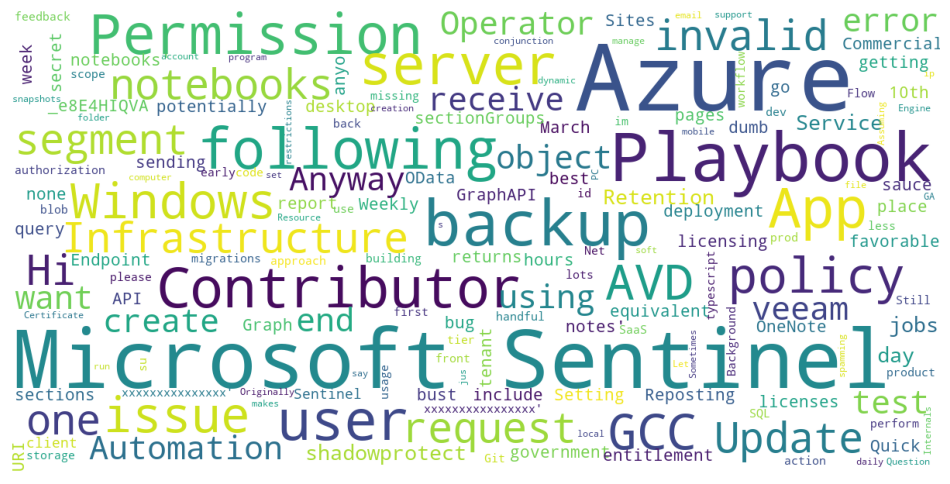

In [33]:
show_wordcloud(df[df['subreddit']=='AZURE']['fullmessage'])

### EDA, Feature Engineering

This sections prepares the dataset for training from choosing the relevant columns into X and y (target) from the combined dataset we get from the csv file above.

* 0 for subreddit AWS
* 1 for subreddit AZURE

New features will be generated aside from the word vectors from the "fullmessage" column

* contain_Aws
* contain_Azure
* has comments
* active_author
* subreddit 0(azure) or 1 (aws)
* score
* word_count
* post_age

In [34]:
def word_exist(text, key_words):    
    return any(i in text.lower() for i in key_words)


In [35]:
df['contain_aws'] = df['fullmessage'].apply(lambda x: 1 if word_exist(x, ['amazon', 'aws']) else 0)
df['contain_az'] = df['fullmessage'].apply(lambda x: 1 if word_exist(x, ['microsoft', 'azure']) else 0)

In [36]:
df['timestamp']= pd.to_datetime(df['utc_datetime_str'])

In [37]:
import datetime

def diff_days(post_date):
    now = datetime.datetime.now()
    delta = now - post_date
    return delta.days

df['post_age_days']=df['timestamp'].apply(lambda x: diff_days(x))
df.head(2)

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count,contain_aws,contain_az,timestamp,post_age_days
0,aws,[removed],BrianPRegan,AWS Pricing Add-on for Google Sheets,1,0,2023-03-10 16:28:11,AWS Pricing Add-on for Google Sheets,36,6,1,0,2023-03-10 16:28:11,3
2,aws,"We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth.\n\nWell there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass.\n\nIf a aws VPN is set the ""dynamic"" will it only pass routes it learns via BGP? You can't add a static also?",silicondt,VPN - dynamic - can we put one static also?,1,0,2023-03-10 15:20:34,"VPN - dynamic - can we put one static also? We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth. Well there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass. If a aws VPN is set the ""dynamic"" will it only pass routes it learns ...",433,94,1,0,2023-03-10 15:20:34,3


In [38]:
df['has_comments']=df['num_comments'].apply(lambda x: 1 if x>=1 else 0 )
df['target'] = df['subreddit'].map({'aws':1, 'AZURE':0})

In [39]:
df[df['target'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count,contain_aws,contain_az,timestamp,post_age_days,has_comments,target
2049,u_Cloudvisor-AWS,NaN,Cloudvisor-AWS,[TRAINING + GUARANTEED JOB OFFER ] Switch from a mid-level developer to a DevOps in a month!,1,0,2023-01-10 11:37:36,[TRAINING + GUARANTEED JOB OFFER ] Switch from a mid-level developer to a DevOps in a month!,92,17,0,0,2023-01-10 11:37:36,63,0,NaN
2093,u_Cloudvisor-AWS,NaN,Cloudvisor-AWS,[JOB OFFER + TRAINING] Go from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,1,0,2023-01-09 14:55:14,[JOB OFFER + TRAINING] Go from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,96,17,1,0,2023-01-09 14:55:14,63,0,NaN
2291,u_Cloudvisor-AWS,NaN,Cloudvisor-AWS,[JOB OFFER + TRAINING] Switch from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,1,0,2023-01-03 11:59:22,[JOB OFFER + TRAINING] Switch from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,100,17,1,0,2023-01-03 11:59:22,70,0,NaN
2292,u_Cloudvisor-AWS,NaN,Cloudvisor-AWS,[JOB OFFER + TRAINING] Switch from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,1,0,2023-01-03 11:58:18,[JOB OFFER + TRAINING] Switch from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,100,17,1,0,2023-01-03 11:58:18,70,0,NaN
2293,u_Cloudvisor-AWS,NaN,Cloudvisor-AWS,[JOB OFFER + TRAINING] Switch from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,1,0,2023-01-03 11:57:49,[JOB OFFER + TRAINING] Switch from Mid/Senior Developer to DevOps working with AWS Cloud in 1 month!,100,17,1,0,2023-01-03 11:57:49,70,0,NaN
2579,u_Cloudvisor-AWS,NaN,Cloudvisor-AWS,"[COURSE + JOB OFFER ] Are you a mid-level developer, looking to become a DevOps?",1,0,2022-12-22 10:34:03,"[COURSE + JOB OFFER ] Are you a mid-level developer, looking to become a DevOps?",80,15,0,0,2022-12-22 10:34:03,82,0,NaN
3482,u_Grand-Azure,NaN,Grand-Azure,=== Cyber Nun ===,1,0,2022-11-08 22:00:23,=== Cyber Nun ===,17,4,0,0,2022-11-08 22:00:23,125,0,NaN


In [40]:
df.dropna(subset=['target'],inplace=True)
df['target'].value_counts()

0.0    4968
1.0    4902
Name: target, dtype: int64

In [41]:
df['target']=df['target'].astype(int)

In [42]:
invalid_char_list = ['\#','\{','\}','\\']

df['contain_invalid_char'] = df['fullmessage'].apply(lambda x: 1 if word_exist(x, invalid_char_list) else 0)

In [43]:
df.columns

Index(['subreddit', 'selftext', 'author', 'title', 'score', 'num_comments',
       'utc_datetime_str', 'fullmessage', 'text_length', 'text_word_count',
       'contain_aws', 'contain_az', 'timestamp', 'post_age_days',
       'has_comments', 'target', 'contain_invalid_char'],
      dtype='object')

In [44]:
df['contain_invalid_char'].value_counts()

0    9393
1     477
Name: contain_invalid_char, dtype: int64

In [45]:
df[df['contain_invalid_char']==1]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count,contain_aws,contain_az,timestamp,post_age_days,has_comments,target,contain_invalid_char
10,aws,[removed],Andromeda_UYScuti,"""error"":""UnauthorizedOperation: You are not authorized to perform this operation.\n\tstatus code: 403 - AWS loadbalancer controller",1,0,2023-03-10 10:15:07,"""error"":""UnauthorizedOperation: You are not authorized to perform this operation.\n\tstatus code: 403 - AWS loadbalancer controller",131,15,1,0,2023-03-10 10:15:07,4,0,1,1
46,aws,"Hey there,\n\nI just recognized AWS Beanstalk has a new design. At least the design is new for me since I last checked \~ 2 weeks ago. \nThe problem: After editing the env variables in the setttings its just doing nothing. The button is for a few seconds deactivated and looks like its processing something but in the end no updates to the variables are saved.\n\nAnyone else got this problem?",Preavee,Can't update env variables after beanstalk design update,1,0,2023-03-09 12:17:40,"Can't update env variables after beanstalk design update Hey there, I just recognized AWS Beanstalk has a new design. At least the design is new for me since I last checked \ 2 weeks ago. The problem: After editing the env variables in the setttings its just doing nothing. The button is for a few seconds deactivated and looks like its processing something but in the end no updates to the varia...",441,79,1,0,2023-03-09 12:17:40,5,0,1,1
67,aws,"We have sveral different AWS environments that have the same deployed JAVA lambdas (not necessarily the same code version, but we have all of our environments aligned at the moment).\n\nEach lambda uses the same jar file as other lambdas in the same environment as its source code, but calls a different starting point as the handler. \n\nThe way those lambdas are called is through API Gateway, ...",Jumbala102,Sudden severe cold start issues with JAVA lambdas,1,0,2023-03-08 20:44:00,"Sudden severe cold start issues with JAVA lambdas We have sveral different AWS environments that have the same deployed JAVA lambdas (not necessarily the same code version, but we have all of our environments aligned at the moment). Each lambda uses the same jar file as other lambdas in the same environment as its source code, but calls a different starting point as the handler. The way those ...",3641,648,1,0,2023-03-08 20:44:00,5,0,1,1
83,aws,"We have a DB instance that periodically gets under a heavy insert load (100GB gp2). We have encountered behavior that we can't explain. When we look at monitoring on IOPS/Network throughput/Disk throughput it seems that every 5 minutes the thoughput increases by \~200 IOPS. Does AWS actually burst the instances in steps? I always thought that once it gets burst, it runs in full speed?\n\n \nT...",malejpavouk,Does AWS RDS T3/GP2 burst in steps?,1,0,2023-03-08 15:31:20,Does AWS RDS T3/GP2 burst in steps? We have a DB instance that periodically gets under a heavy insert load (100GB gp2). We have encountered behavior that we can't explain. When we look at monitoring on IOPS/Network throughput/Disk throughput it seems that every 5 minutes the thoughput increases by \200 IOPS. Does AWS actually burst the instances in steps? I always thought that once it gets bur...,439,75,1,0,2023-03-08 15:31:20,5,0,1,1
89,aws,"We are working on a system in which one microservice publishes an event on a bus and many others microservices are subscribed to that bus.\n\n&amp;#x200B;\n\nSome of the subscribed microservices want to filter the messages so that they only receives events where one of the attributes on the message contains certain values. EventBridge and SNS both provide filtering capabilities, however in thi...",humantarget22,Filtering messages on one of thousands of values in AWS?,1,0,2023-03-08 12:33:43,Filtering messages on one of thousands of values in AWS? We are working on a system in which one microservice publishes an event on a bus 

In [46]:
df = df[df['contain_invalid_char']==0]
df['target'].value_counts()

1    4707
0    4686
Name: target, dtype: int64

In [47]:
df.isna().sum()

subreddit                  0
selftext                1815
author                     0
title                      0
score                      0
num_comments               0
utc_datetime_str           0
fullmessage                0
text_length                0
text_word_count            0
contain_aws                0
contain_az                 0
timestamp                  0
post_age_days              0
has_comments               0
target                     0
contain_invalid_char       0
dtype: int64

In [48]:
df.to_csv('..\data\data_clean.csv')